## Read in data

In [1]:
import json

rumour_list = []
for x in open("rumour.jsonl", "r").readlines():
    rumour_list.append(json.loads(x.strip()))

nonrumour_list = []
for x in open("nonrumour.jsonl", "r").readlines():
    nonrumour_list.append(json.loads(x.strip()))

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        if t.startswith("@") and len(t) >= 1:
            new_text.append("<USER>")
        elif t.startswith("http") and len(t) >= 4:
            new_text.append("<URL>")
        else:
            new_text.append(t)
    return " ".join(new_text)

rumour_text = [preprocess(x["text"]) for x in rumour_list]
nonrumour_text = [preprocess(x["text"]) for x in nonrumour_list]

## Top-10 Topics of COVID-19 rumours and non-rumours

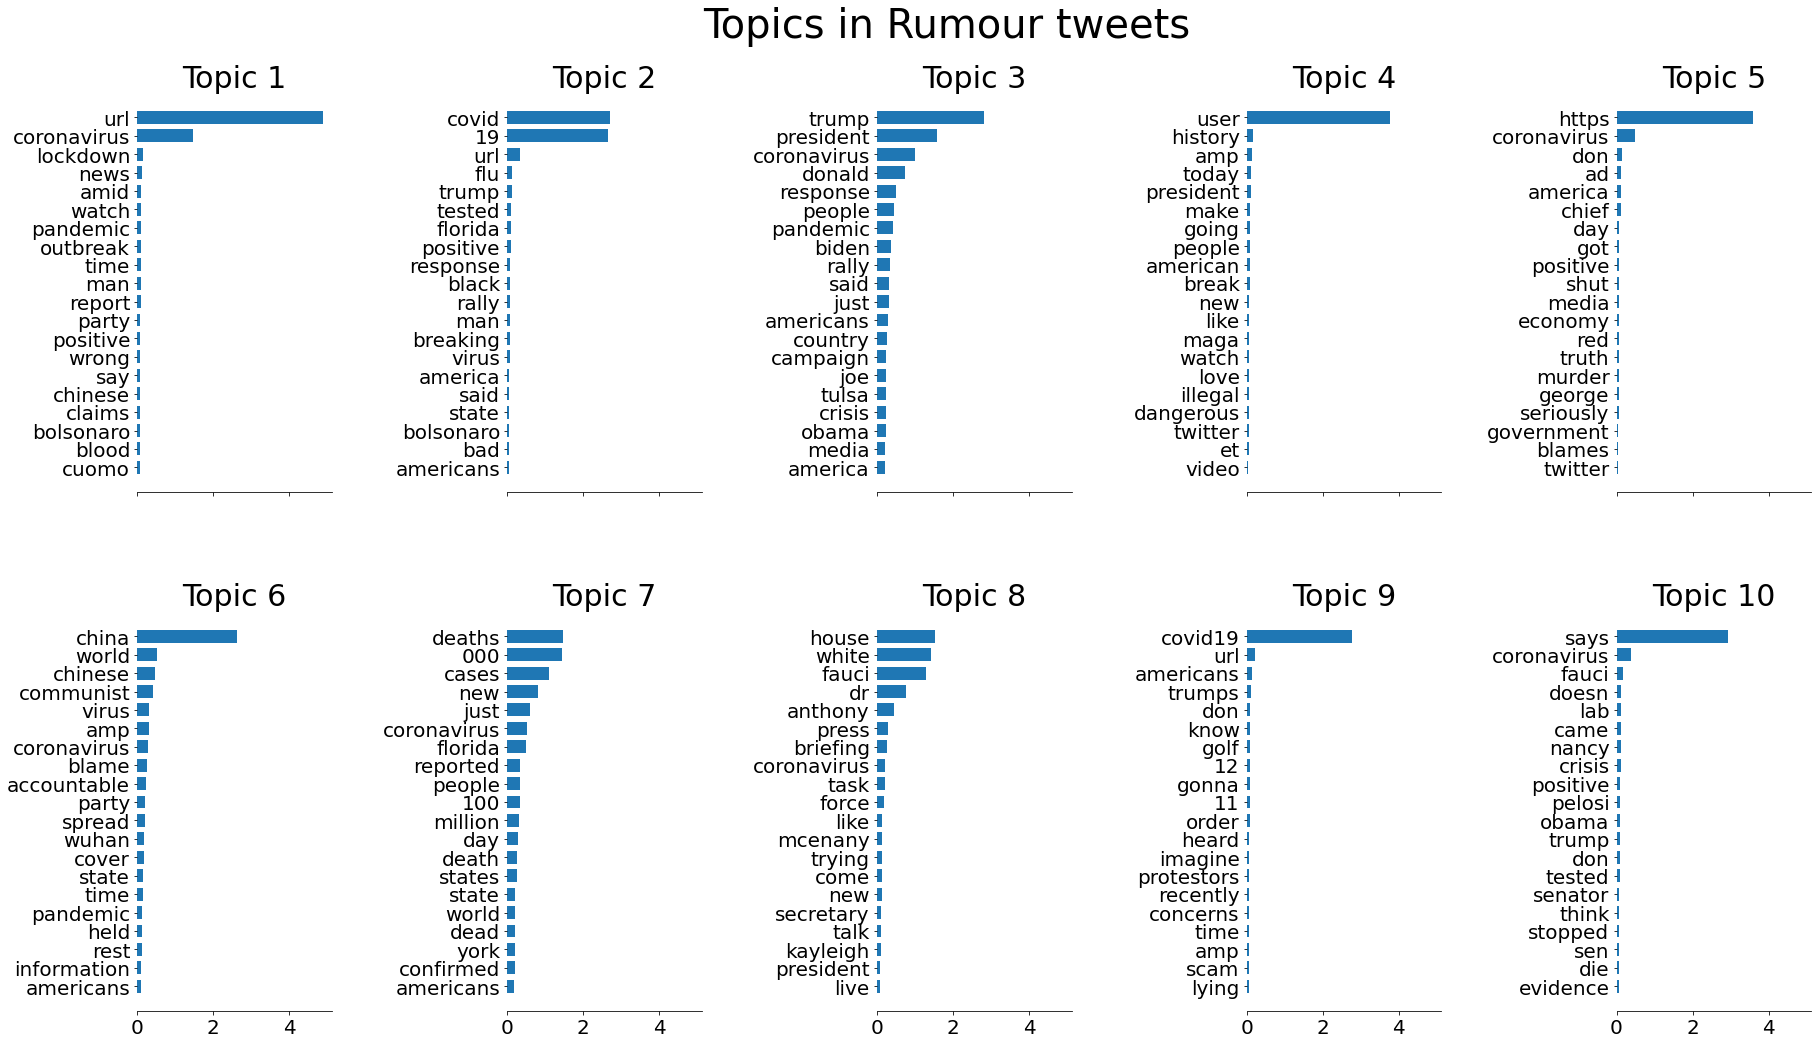

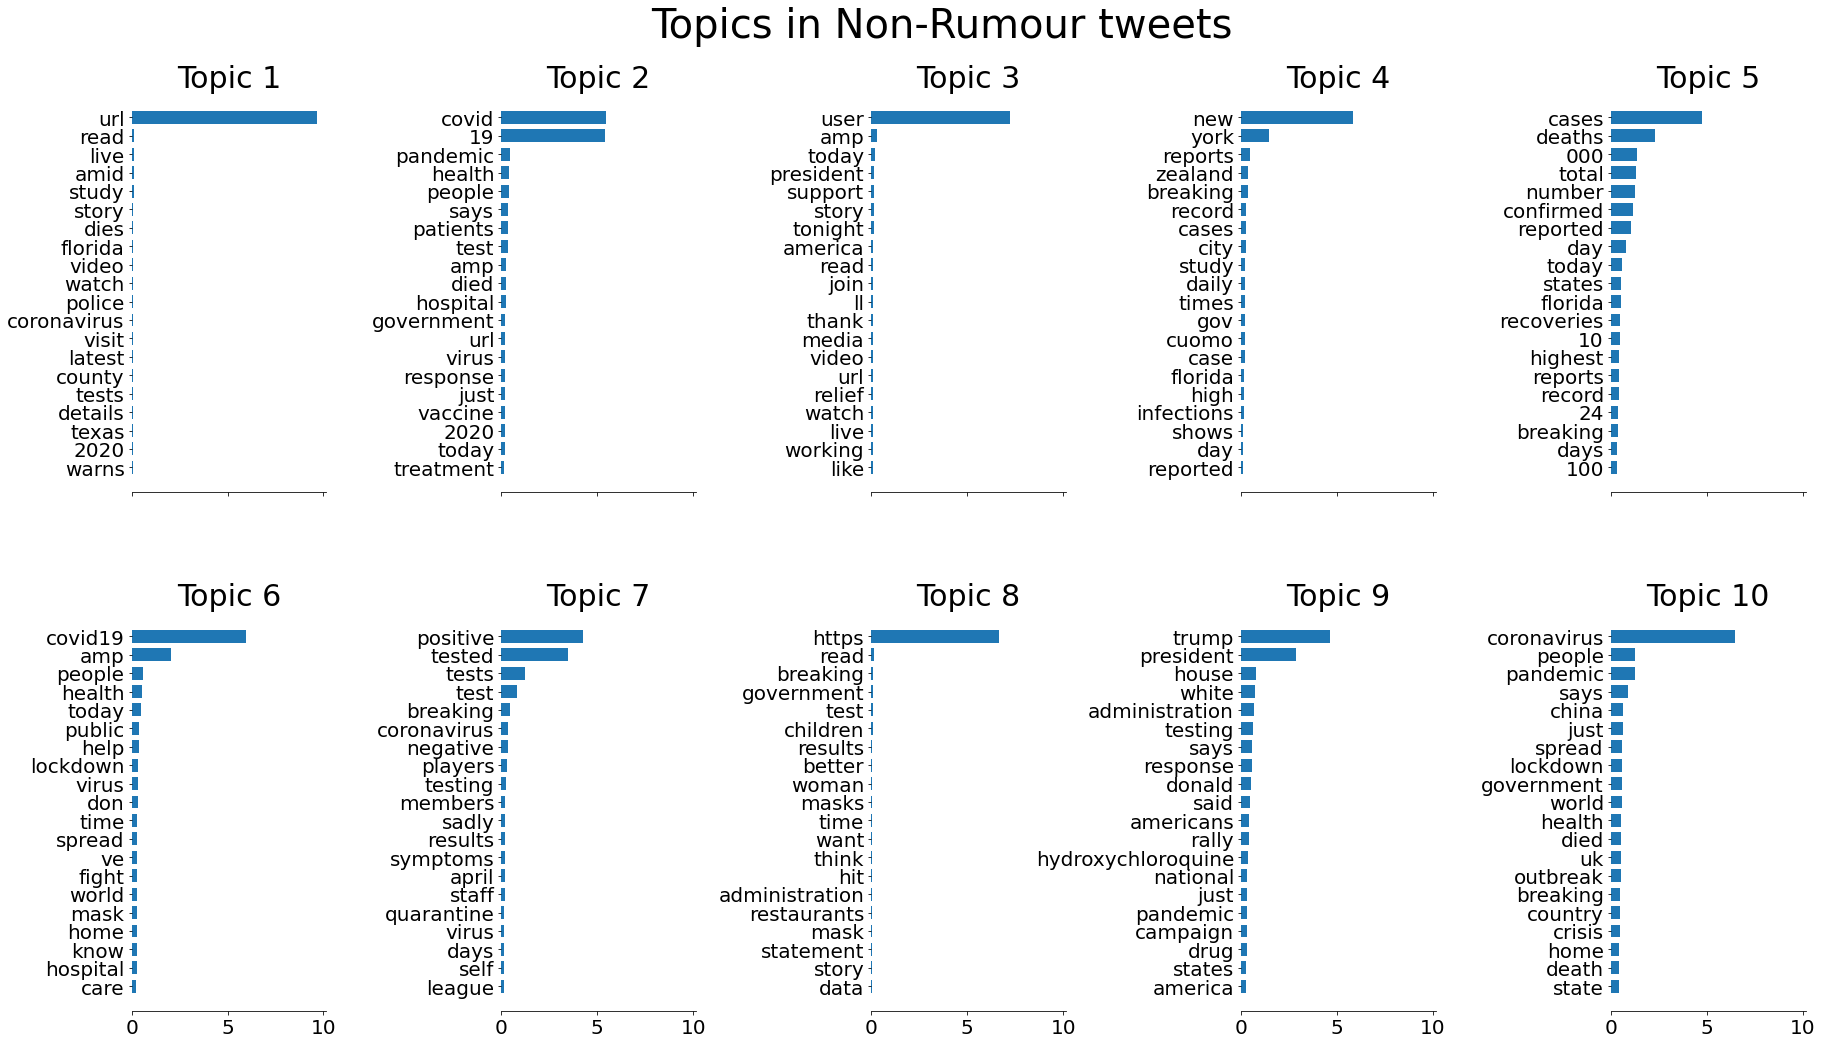

In [2]:
# Reference: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
#from sklearn.datasets import fetch_20newsgroups

n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


rumour_data = rumour_text
nonrumour_data = nonrumour_text

# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(rumour_data)

# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(rumour_data)

# Fit the NMF model
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in Rumour tweets"
)

# Use tf-idf features for NMF.
tfidf = tfidf_vectorizer.fit_transform(nonrumour_data)

# Fit the NMF model
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in Non-Rumour tweets"
)

Comments: As we can see from the above plots, the topics in the rumour tweets are similar to the topics in the non-rumour tweets. However, rumour tweets focus on the topics that are related to China in Topic 6. The non-rumour tweets focus on the topics that are related to the US in Topic 4.

## Rumour topics evolve over time

In [3]:
import time
rumour_text = [preprocess(x["text"]) for x in rumour_list]
json_list = sorted(rumour_list, key=lambda x: time.mktime(time.strptime(x["created_at"], '%Y-%m-%dT%H:%M:%S.%fZ')))
# get unique months in created_at
month_list = []
for i in range(len(json_list)):
    if i == 0:
        month_list.append(json_list[i]["created_at"][:7])
    else:
        if json_list[i]["created_at"][:7] != json_list[i-1]["created_at"][:7]:
            month_list.append(json_list[i]["created_at"][:7])

print(month_list)

['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08']


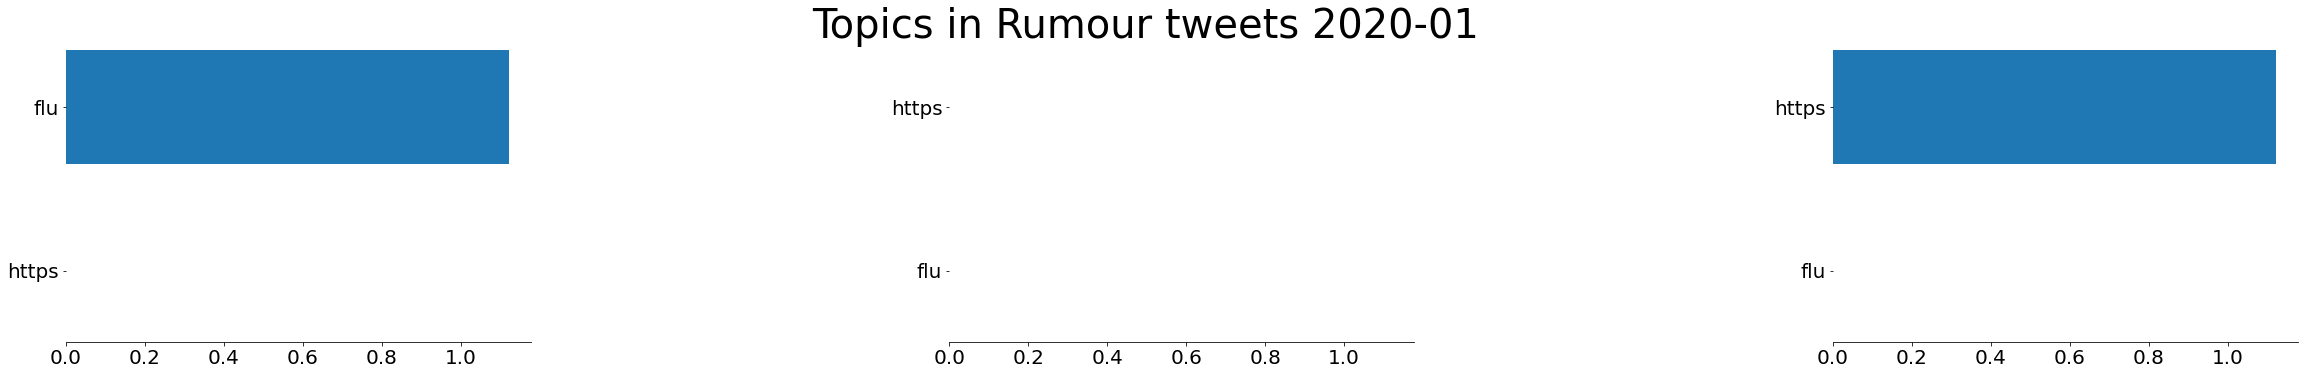

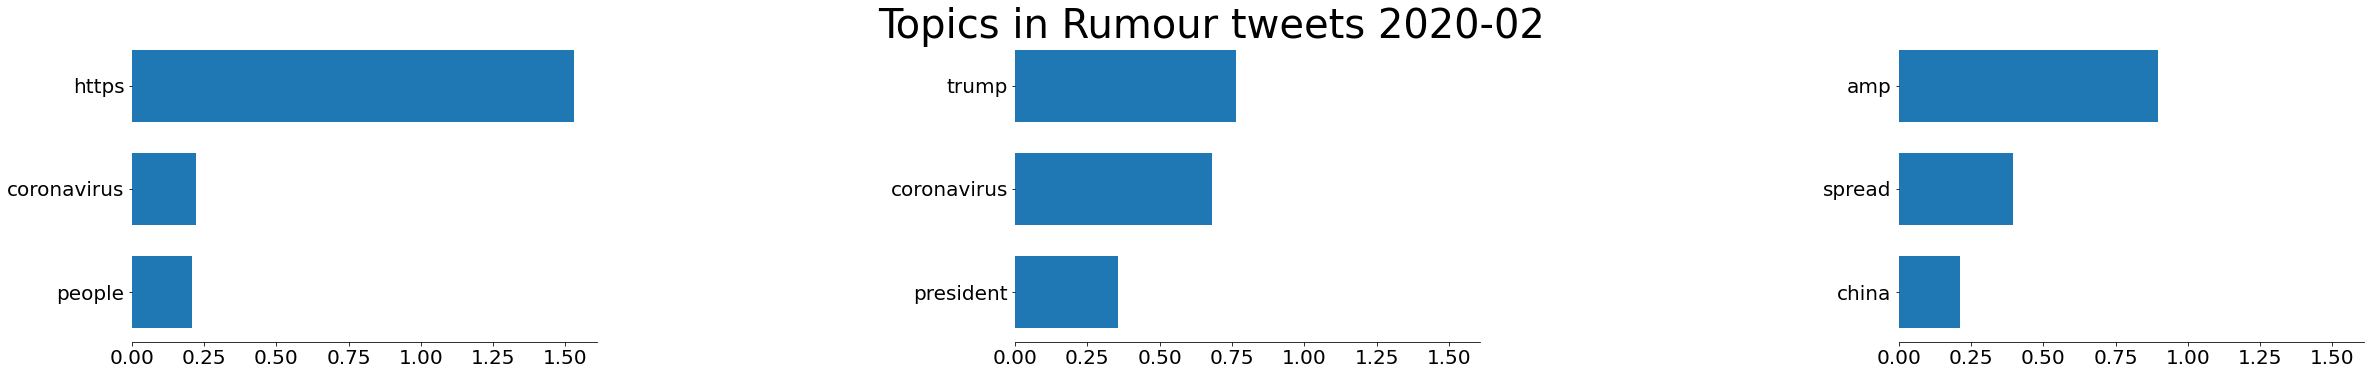

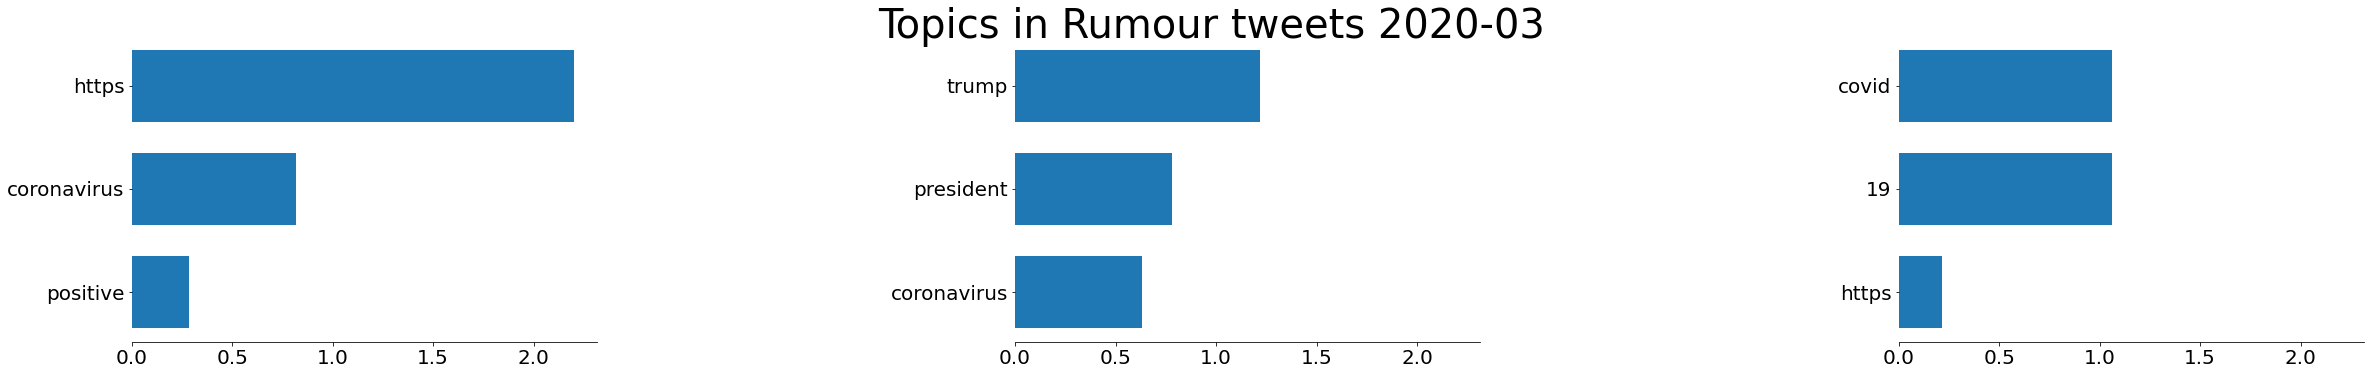

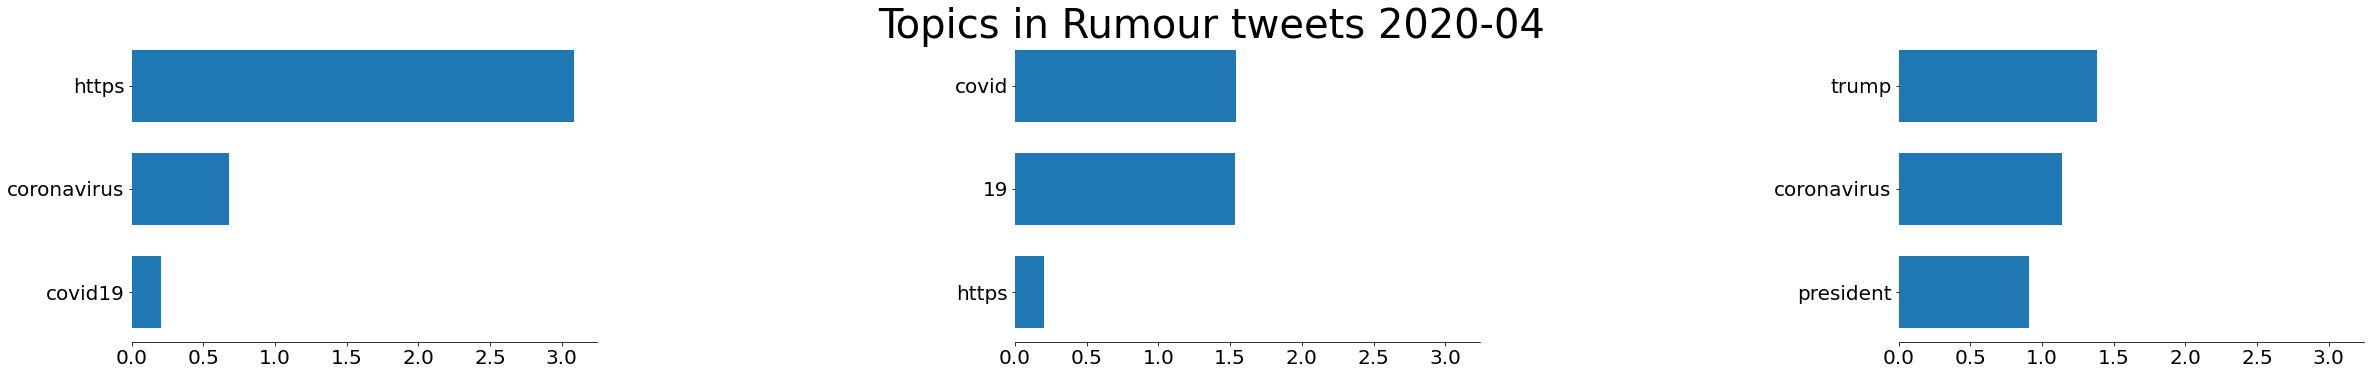

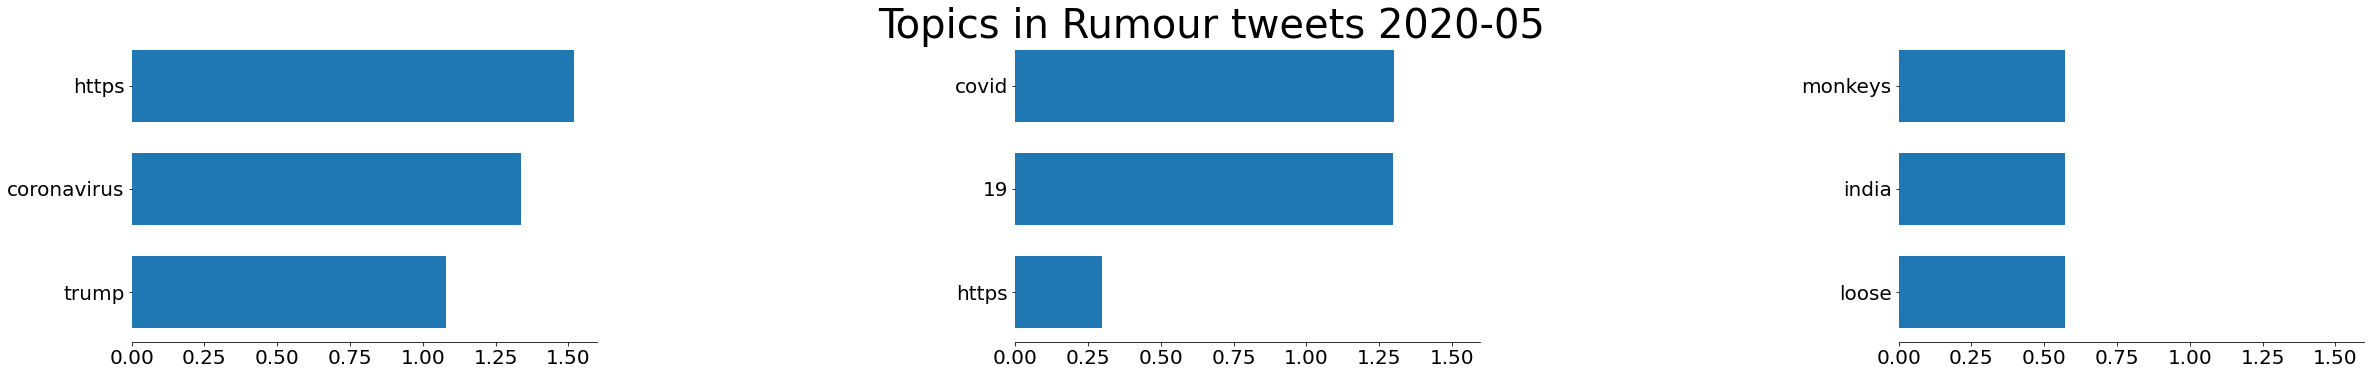

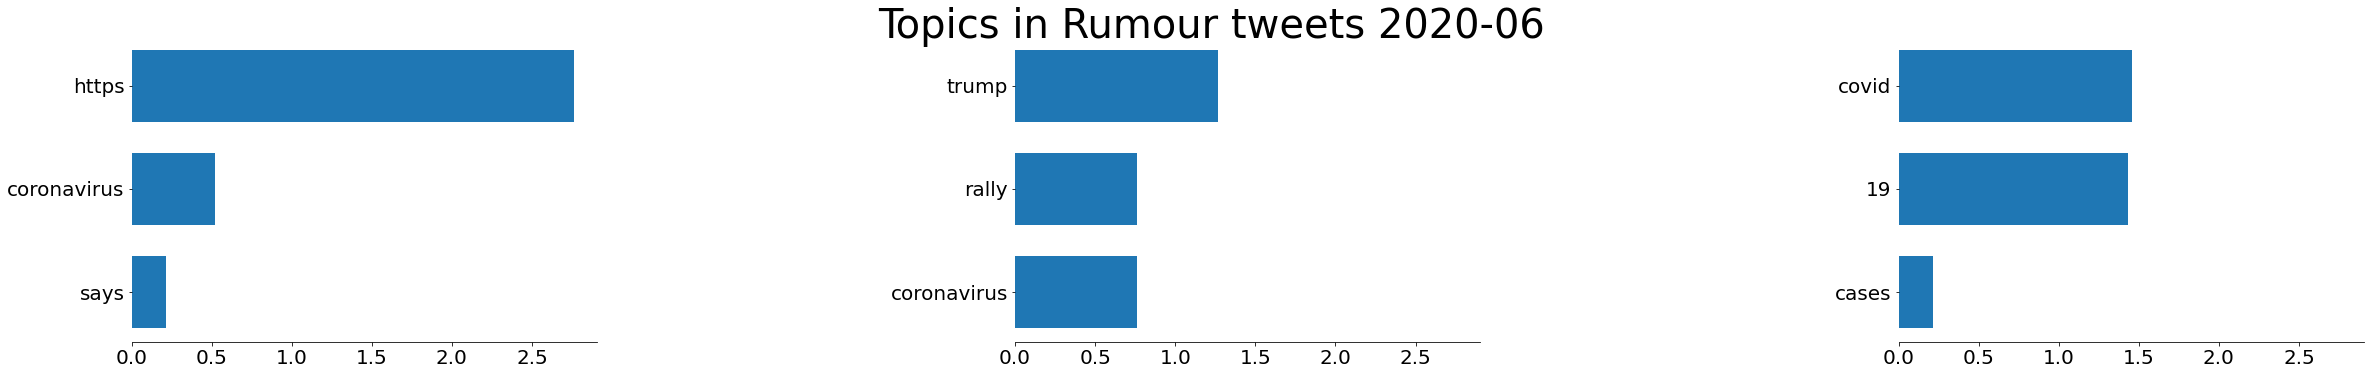

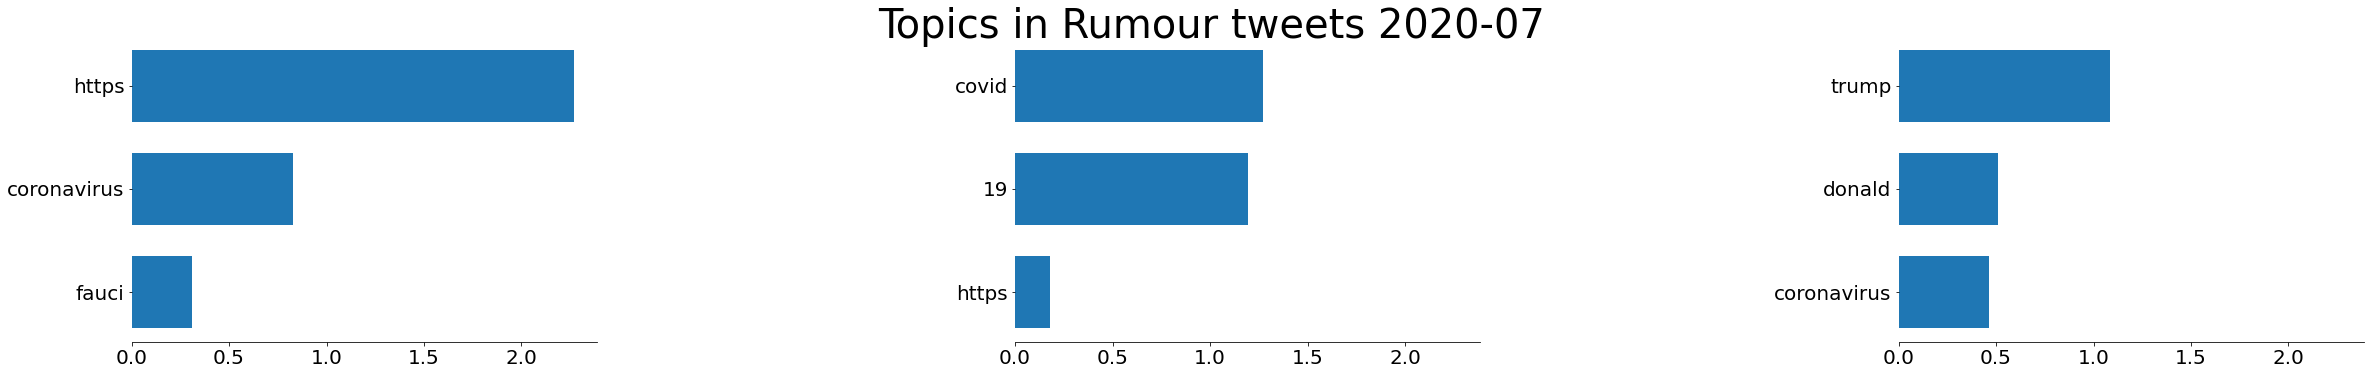

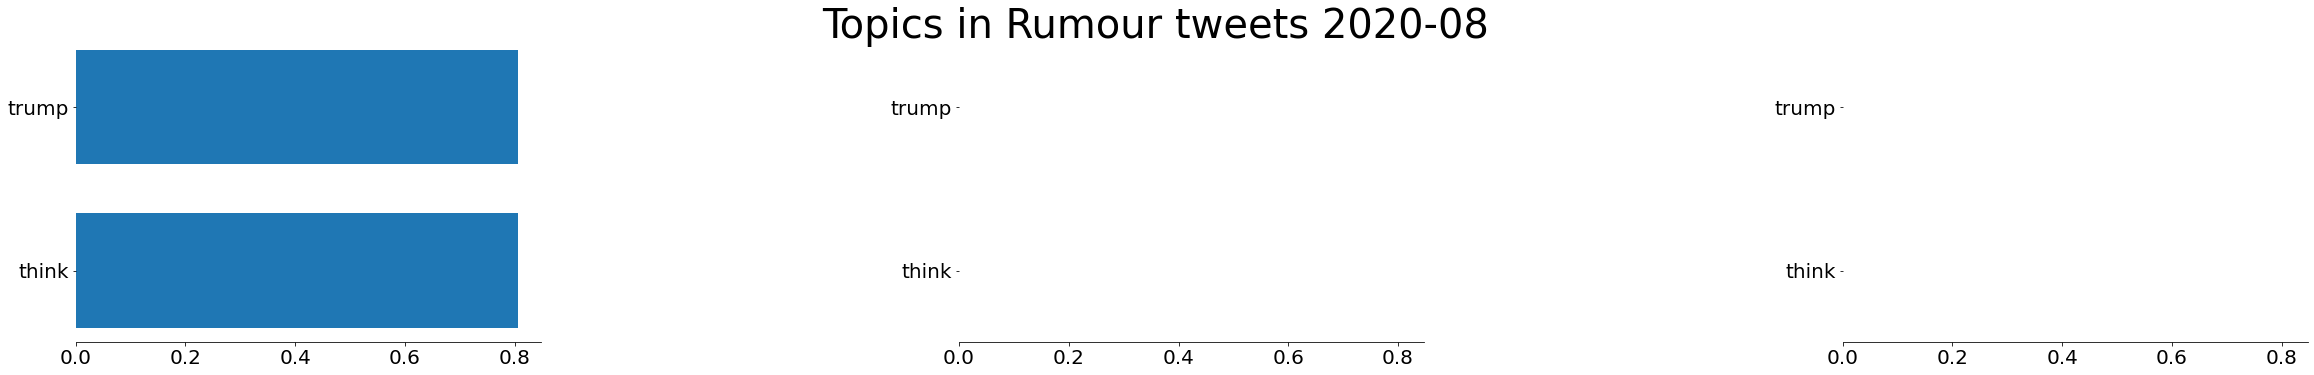

In [4]:
# get tweets in each month
month_tweets = []
for i in range(len(month_list)):
    month_tweets.append([])
for i in range(len(json_list)):
    for j in range(len(month_list)):
        if json_list[i]["created_at"][:7] == month_list[j]:
            month_tweets[j].append(json_list[i]["text"])

n_features = 1000
n_components = 3
n_top_words = 3

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(40, 5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
for i in range(len(month_tweets)):
    # Use tf-idf features for NMF.
    tfidf = tfidf_vectorizer.fit_transform(month_tweets[i])
    # Use tf (raw term count) features for LDA.
    #tf = tf_vectorizer.fit_transform(month_tweets[i])
    # Fit the NMF model
    nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)


    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    plot_top_words(
        nmf, tfidf_feature_names, n_top_words, "Topics in Rumour tweets" + " " + month_list[i]
    )

Comments: As we can see from the above plots, with the period from 2020-01 to 2020-08, the rumour topics change a lot. It firstly saw COVID-19 as normal flu and then focus on China spreading the virus. The topics about Trump related with COVID-19 are always in the rumour tweets.

## Popular hashtags

In [5]:
from collections import Counter
rumour_hashtags = Counter()
nonrumour_hashtags = Counter()

for x in rumour_list:
    if "entities" in x and "hashtags" in x["entities"]:
        for y in x["entities"]["hashtags"]:
            tag = y["tag"].lower()
            rumour_hashtags[tag] = rumour_hashtags.get(tag, 0) + 1

for x in nonrumour_list:
    if "entities" in x and "hashtags" in x["entities"]:
        for y in x["entities"]["hashtags"]:
            tag = y["tag"].lower()
            nonrumour_hashtags[tag] = nonrumour_hashtags.get(tag, 0) + 1

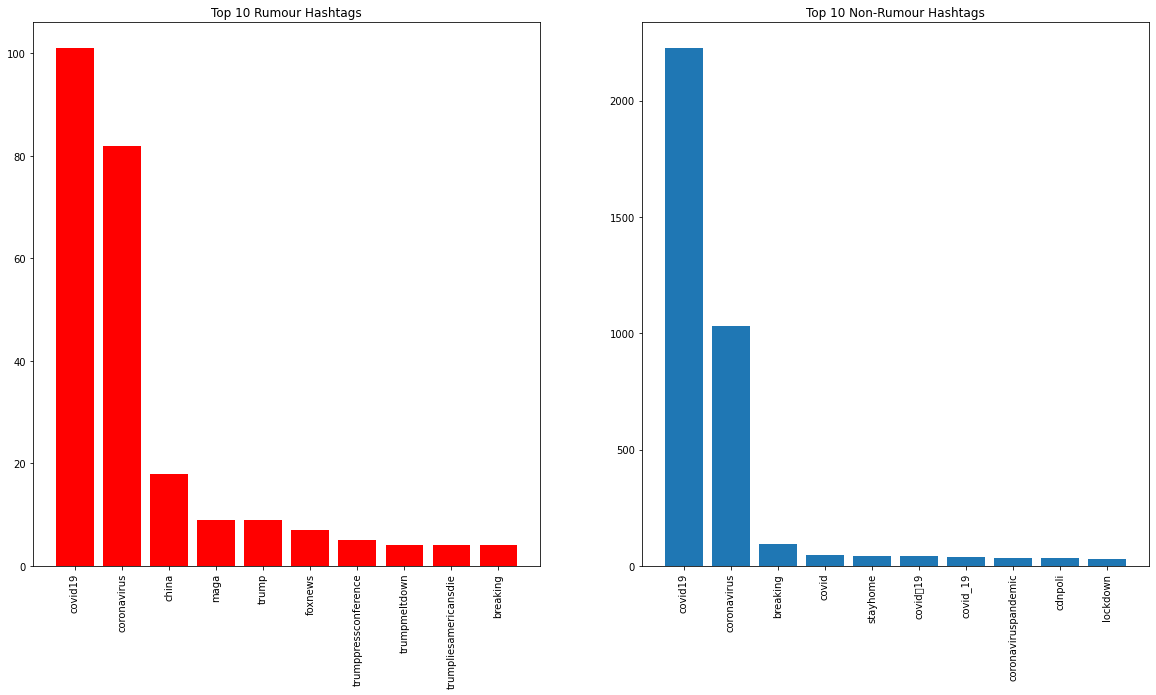

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
# make dataframe of hashtags
rumour_df = pd.DataFrame({"rumour_hashtag": [key for (key,value) in rumour_hashtags.most_common(10)],
                            "rumour_count": [value for (key,value) in rumour_hashtags.most_common(10)]})
nonrumour_df = pd.DataFrame({"nonrumour_hashtag": [key for (key,value) in nonrumour_hashtags.most_common(10)],
                            "nonrumour_count": [value for (key,value) in nonrumour_hashtags.most_common(10)]})

# combine dataframes column-wise
combined_df = pd.concat([rumour_df, nonrumour_df], axis=1)
# split into two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# plot rumour hashtags in first subplot
ax[0].bar(combined_df["rumour_hashtag"], combined_df["rumour_count"], color="red")
# rotate the plot with 90 degrees
ax[0].set_xticklabels(combined_df["rumour_hashtag"], rotation=90)
# plot non-rumour hashtags in second subplot
ax[1].bar(combined_df["nonrumour_hashtag"], combined_df["nonrumour_count"])
ax[1].set_xticklabels(combined_df["nonrumour_hashtag"], rotation=90)
# set title
ax[0].set_title("Top 10 Rumour Hashtags")
ax[1].set_title("Top 10 Non-Rumour Hashtags")
# show plot
plt.show()

Comments: The top 10 hashtags in rumour tweets and non-rumour tweets are mostly similar. However, rumour hashtags focus more on China and Trump compared to non-rumour hashtags.

## Sentiment analysis

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1045)>


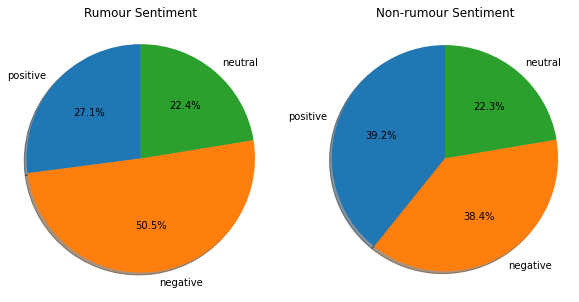

In [8]:
def sentiment_analysis(tweet):
    score = analyzer.polarity_scores(tweet)
    if score["compound"] > 0.05:
        return "positive"
    elif score["compound"] < -0.05:
        return "negative"
    else:
        return "neutral"

# count the number of positive, negative and neutral tweets
rumour_sentiment = {
    "positive": 0,
    "negative": 0,
    "neutral": 0
}
nonrumour_sentiment = {
    "positive": 0,
    "negative": 0,
    "neutral": 0
}
for x in rumour_list:
    if sentiment_analysis(x["text"]) == "positive":
        rumour_sentiment["positive"] += 1
    elif sentiment_analysis(x["text"]) == "negative":
        rumour_sentiment["negative"] += 1
    else:
        rumour_sentiment["neutral"] += 1

for x in nonrumour_list:
    if sentiment_analysis(x["text"]) == "positive":
        nonrumour_sentiment["positive"] += 1
    elif sentiment_analysis(x["text"]) == "negative":
        nonrumour_sentiment["negative"] += 1
    else:
        nonrumour_sentiment["neutral"] += 1

import matplotlib.pyplot as plt

# plot the results in a pie chart
# two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# put one pie chart in the left half of the figure
ax1.pie([rumour_sentiment["positive"], rumour_sentiment["negative"], rumour_sentiment["neutral"]],
        labels=["positive", "negative", "neutral"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# add a title
ax1.set_title('Rumour Sentiment')
# put the second pie chart in the right half of the figure
ax2.pie([nonrumour_sentiment["positive"], nonrumour_sentiment["negative"], nonrumour_sentiment["neutral"]],
        labels=["positive", "negative", "neutral"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# add a title
ax2.set_title('Non-rumour Sentiment')
plt.show()

Comments: As we can see from two pie charts, the rumours sentiment is mostly negative which covers 50.5% of the tweets. The non-rumour sentiment has a half-half situation that positive and negative tweets have a similar proportion.

## Rumour users analysis

#### crawl user information

In [9]:
# reference: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/User-Lookup/get_users_with_bearer_token.py
# get user fields based on author_id
rumour_auther_id = [x["author_id"] for x in rumour_list]
rumour_auther_id = list(set(rumour_auther_id))
nonrumour_auther_id = [x["author_id"] for x in nonrumour_list]
nonrumour_auther_id = list(set(nonrumour_auther_id))

import requests
import json
from tqdm import tqdm

# To set your enviornment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token ="AAAAAAAAAAAAAAAAAAAAAGdZbgEAAAAAlXMiIg%2F96Ygnv%2FmvFDMsWb6LuSw%3DPTSIRz5g0G9RaB9pxp8QhdTtHxXnhEZsjLkpNyqQBR8EfRy8WS"



def create_url(ids):
    # Specify the usernames that you want to lookup below
    # You can enter up to 100 comma-separated values.
    ids = "ids="+ids
    user_fields = "user.fields=description,created_at,location,verified,protected"
    # User fields are adjustable, options include:
    # created_at, description, entities, id, location, name,
    # pinned_tweet_id, profile_image_url, protected,
    # public_metrics, url, username, verified, and withheld
    url = "https://api.twitter.com/2/users?{}&{}".format(ids, user_fields)
    return url


def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r


def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

def crawl(train_id_list):
    start_id = 0
    end_id = start_id + 100
    train_id_len = len(train_id_list)
    # max 100 tweet
    split_crawl = []
    user_info = []
    while start_id < train_id_len:
        split_crawl.append(",".join(train_id_list[start_id:end_id]))
        start_id = end_id
        end_id = start_id + 100

    crawl_count = 0
    for ids in tqdm(split_crawl):
        url = create_url(ids)
        json_response = connect_to_endpoint(url)
        for x in json_response["data"]:
            user_info.append(x)
        crawl_count += 1
        if crawl_count % 290 == 0:
            print(crawl_count*100,"crawled, sleeping for 790 seconds")
            time.sleep(790)
    return user_info


rumour_user_info = crawl(rumour_auther_id)
nonrumour_user_info = crawl(nonrumour_auther_id)
print("crawl done")

100%|██████████| 56/56 [00:40<00:00,  1.37it/s]

crawl done


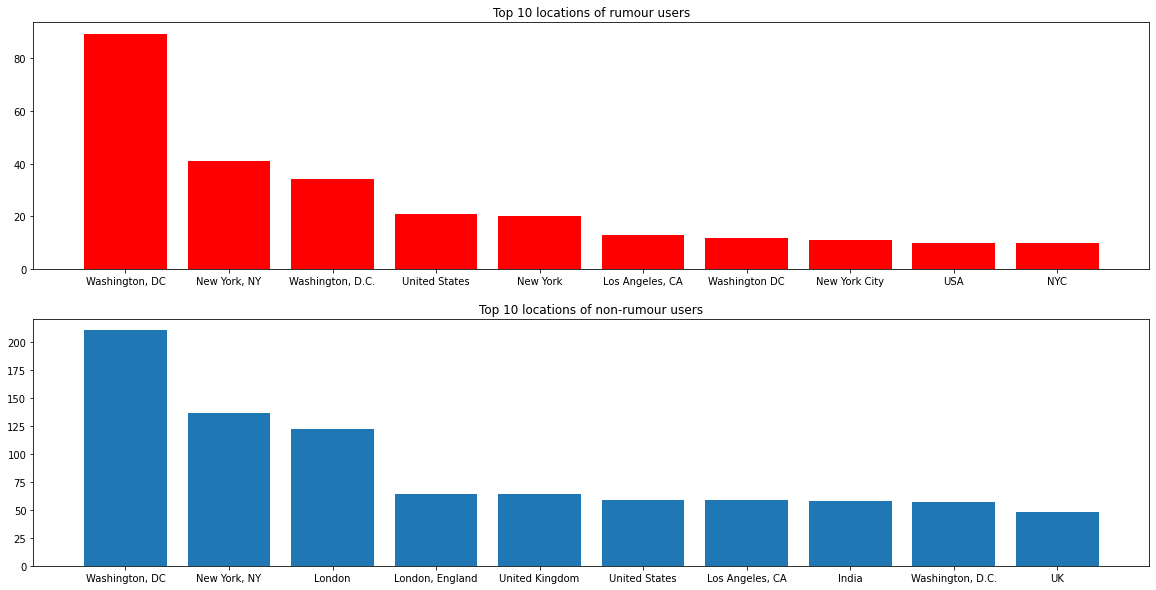

In [10]:
from collections import Counter

# location of rumour users
rumour_location = Counter([x["location"] for x in rumour_user_info if "location" in x])
nonrumour_location = Counter([x["location"] for x in nonrumour_user_info if "location" in x])

top10_rumour_location = rumour_location.most_common(10)
top10_nonrumour_location = nonrumour_location.most_common(10)
# split plot into two subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
# plot top 10 location of rumour users in the first subplot
axs[0].bar(range(len(top10_rumour_location)), [x[1] for x in top10_rumour_location], color="r")
axs[0].set_xticks(range(len(top10_rumour_location)))
axs[0].set_xticklabels([x[0] for x in top10_rumour_location])
axs[0].set_title("Top 10 locations of rumour users")
# plot top 10 location of non-rumour users in the second subplot
axs[1].bar(range(len(top10_nonrumour_location)), [x[1] for x in top10_nonrumour_location])
axs[1].set_xticks(range(len(top10_nonrumour_location)))
axs[1].set_xticklabels([x[0] for x in top10_nonrumour_location])
axs[1].set_title("Top 10 locations of non-rumour users")
plt.show()

Comments: As we can see from two plots, the top 10 locations of rumour users are totally located in the US, and the top 10 locations of non-rumour users are the US, the UK and India.